In [1]:
import sys
sys.path.append('../modules')

from operators import *
from preprocessing import *
from eof import *
from gridding import *
from mapper import *
from scipy.stats import linregress

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature
import seaborn as sns
import pandas as pd

%load_ext autoreload
%autoreload 2

## Snowload
---
Load data and interpolate the design value field

In [2]:
PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/design_values/snw/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load.nc'
mask_path = '/home/nannau/Desktop/climpyrical/data/mask.nc'
dv = 'snw'

interp_dict = get_interpolation(mask_path, PATH, dv)
master_idx = interp_dict['idx']
iens = (interp_dict['iens'][:, master_idx])
vTsne = get_ieof(mask_path, PATH, dv)

iens.shape

(35, 799963)

Plot distribution.

Text(0.5, 1.0, 'KDE Distribution of snw Values')

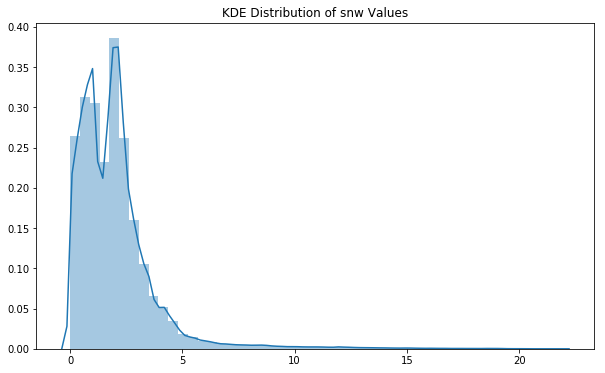

In [3]:
plt.figure(figsize=(10, 6))
sns.distplot(iens[0, ...])
plt.title('KDE Distribution of {} Values'.format(dv))

Perform singular value decomposition

In [4]:
u, s, vT = np.linalg.svd(iens, full_matrices=False)
del u

Calculate explained variance and plot

Text(0, 0.5, 'Explained Variance Ratio')

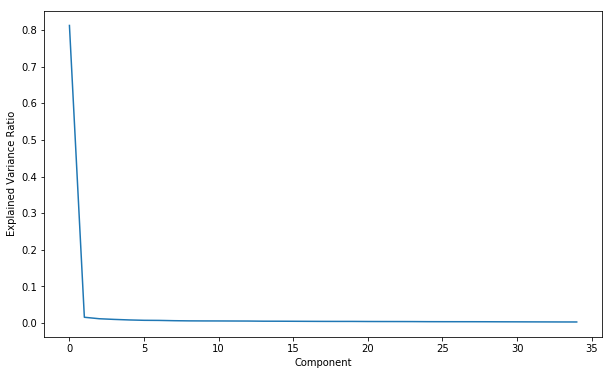

In [5]:
explained_variance_ratio = [s[i]/np.sum(s) for i in range(s.shape[0])]
cumulative_variance = np.cumsum(explained_variance_ratio)
component = range(s.shape[0])

plt.figure(figsize=(10, 6))
plt.plot(component, explained_variance_ratio)
plt.xlabel('Component')
plt.ylabel('Explained Variance Ratio')

Load the quantile station data

In [6]:
df = pd.read_csv('/home/nannau/Downloads/Interim_snow_rain_load_LRstations_delivered.csv', index_col=None)
df.head()

,id,SD_station_name,lat,lon,prov,elevation,SL50 (kPa),RL50 (kPa)
0,15,CHEMAINUS,48.9350,-123.742,BC,75.0,1.954635,0.086293
1,78,SAANICHTON CDA,48.6217,-123.419,BC,61.0,0.729036,0.772268
2,91,SHAWNIGAN LAKE,48.6469,-123.626,BC,159.0,2.352290,0.586493
3,109,VICTORIA GONZALES HTS,48.4131,-123.325,BC,69.5,0.752725,0.764285
4,149,ALERT BAY,50.5833,-126.933,BC,59.4,1.420390,0.564503


In [7]:
dv = 'SL50 (kPa)'

In [8]:
ndf = match_coords(df, interp_dict, dv)
print("There are ", ndf.shape, "real station observations to fit.")

There are  (477, 7) real station observations to fit.


In [9]:
#ndf = ndf[(ndf['prov'] != 'QC') & (ndf['prov'] != 'BC')]
df[(df['SL50 (kPa)'] > 10)]


,id,SD_station_name,lat,lon,prov,elevation,SL50 (kPa),RL50 (kPa),nearest_grid,obs_coords
61,1597,GLACIER NP MT FIDELITY,51.2382,-117.7010,BC,1890.0,20.431056,0.000000,405299,"(5.45128229469057, -12.84537403334695)"
390,7698,DOAKTOWN,46.5525,-66.1403,NB,57.0,10.259908,0.527899,337677,"(3.1668816081319098, 20.688150177613355)"
438,8302,GALLANTS,48.7000,-58.2333,NL,143.0,11.699300,0.380801,394178,"(7.362144133067964, 24.62615250390588)"
440,8353,MIDDLE ARM,49.6833,-56.0833,NL,47.8,14.493389,0.000000,400129,"(8.896623657666789, 25.39955778468893)"
445,8397,ST ANTHONY,51.3667,-55.6000,NL,11.5,11.643355,0.517601,370076,"(10.513143541501316, 24.830079614182484)"
451,8472,BATTLE HARBOUR LOR,52.2500,-55.6000,NL,9.4,10.480149,0.560523,505325,"(11.27986689754487, 24.383441139208454)"
452,8479,CARTWRIGHT,53.7083,-57.0350,NL,14.3,11.418252,0.059610,497268,"(12.126358983270919, 22.883799444538962)"
457,8505,MAKKOVIK A,55.0822,-59.1886,NL,70.4,13.363724,0.114299,498796,"(12.741825670817573, 21.086584257574323)"


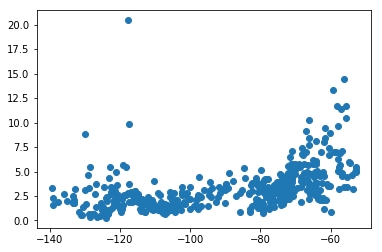

In [10]:
plt.scatter(df['lon'], df['SL50 (kPa)'])

#### Create the pseudo observations and regress

In [11]:
obs_idx = generate_pseudo_obs(iens, 0.0003)
print("Taking", obs_idx.shape[0], "pseudo observations")

Taking 239 pseudo observations


In [12]:
obs = iens[0, obs_idx]
eofs = vT[:, obs_idx]

print("Check that the pseudo observations and the EOFs contain the same number of grids:",
      '\nEOF shape: ', eofs.shape, '\n'
      'Matched Obs shape: ', obs.shape)

Check that the pseudo observations and the EOFs contain the same number of grids: 
EOF shape:  (35, 239) 
Matched Obs shape:  (239,)


Fit the EOFs tot he pseudo observations and predict their values

In [13]:
model = fit_eof(eofs.T, obs.flatten())
predictions = predict_dv(model, eofs.T)

Regressed model score: 1.0 1.0


slope 1.0 r2_val 1.0


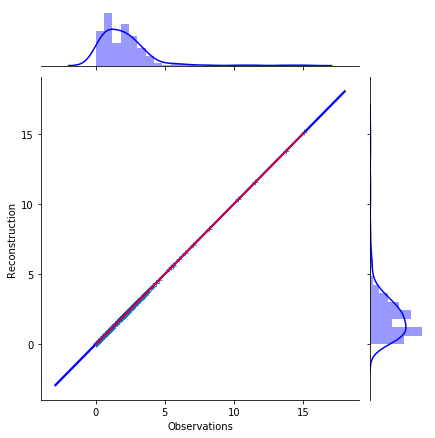

In [14]:
sns.jointplot(obs.T, predictions.T, kind='reg', color='blue',  marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(obs.T, predictions.T, marker='+')
sns.lineplot(obs.T, obs.T, color='r', dashes=True)
plt.xlabel('Observations')
plt.ylabel('Reconstruction')

slope, intercept, r_value, p_value, std_err = linregress(obs.T, predictions.T)
print("slope", slope, "r2_val", r_value)

#### Use the real observations and regress

In [15]:
robs_idx = ndf['matched_idx']
robs = (ndf[dv].values) # fix units
reofs = vT[:, robs_idx].T
reofs.shape, robs.shape, obs.shape

((477, 35), (477,), (239,))

In [16]:
yslopes = []
x = eofs.T

for sd in np.linspace(0, np.std(robs)):
    y = obs.flatten() + np.random.normal(0., sd, obs.flatten().shape[0])
    model = fit_eof(x, y)
    predictions = predict_dv(model, x)
    slope, intercept, r_value, p_value, std_err = linregress(y, predictions)
    yslopes.append(slope)


Regressed model score: 1.0 1.0
Regressed model score: 0.9995188590478149 0.9995188590478149
Regressed model score: 0.9981533853557453 0.9981533853557453
Regressed model score: 0.9959930606376085 0.9959930606376085
Regressed model score: 0.9930035019873619 0.993003501987362
Regressed model score: 0.9897708138073628 0.9897708138073628
Regressed model score: 0.984212218617445 0.984212218617445
Regressed model score: 0.9797993597026571 0.9797993597026571
Regressed model score: 0.9728027473783064 0.9728027473783064
Regressed model score: 0.9708071959514057 0.9708071959514057
Regressed model score: 0.953789357201871 0.953789357201871
Regressed model score: 0.9510685696211211 0.9510685696211211
Regressed model score: 0.9487834554942649 0.9487834554942649
Regressed model score: 0.9231878284087957 0.9231878284087957
Regressed model score: 0.9199649557555291 0.9199649557555291
Regressed model score: 0.9101947089223233 0.9101947089223233
Regressed model score: 0.8848871497842057 0.884887149784205

Text(0, 0.5, 'Slope/R$^2$ Score')

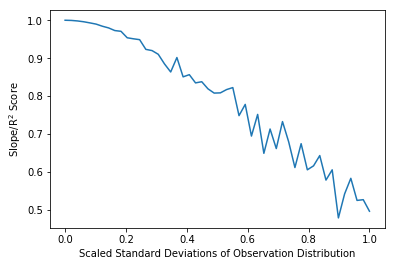

In [17]:
plt.plot(np.linspace(0, np.std(robs))/np.std(robs), yslopes)
plt.xlabel('Scaled Standard Deviations of Observation Distribution')
plt.ylabel('Slope/R$^2$ Score')

Compare the distributions of the station observations and of the models

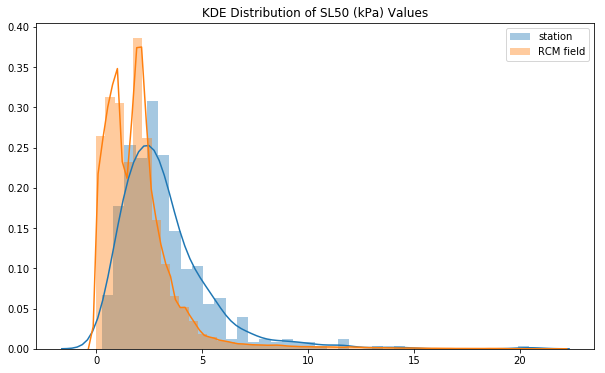

In [18]:
plt.figure(figsize=(10, 6))
plt.title('KDE Distribution of {} Values'.format(dv))
sns.distplot(robs, label='station')
sns.distplot(iens[0, ...], label='RCM field')
plt.legend()

Fit the model and predict it

In [19]:
rmodel = fit_eof(reofs, robs.flatten())
linrpredictions = predict_dv(rmodel, reofs).flatten()
linrpredictions.shape

Regressed model score: 0.310929775099988 0.310929775099988


(477,)

slope 0.310929775099988 r2_val 0.5576107738377979
Std deviation ratio of vectors [models/]: 0.8513859990535372


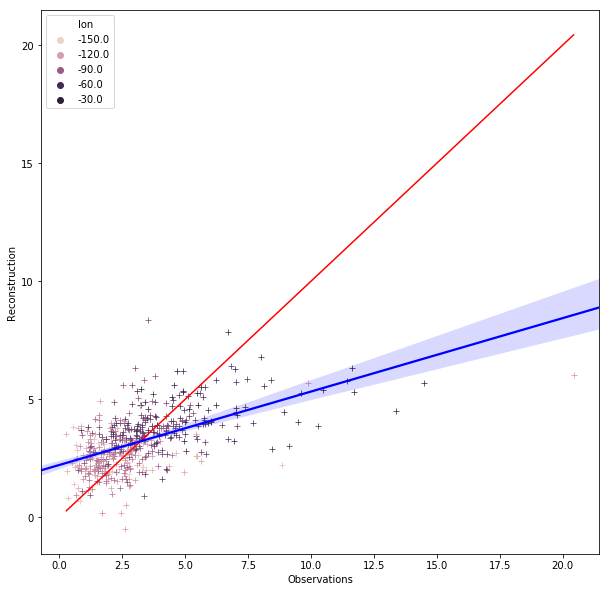

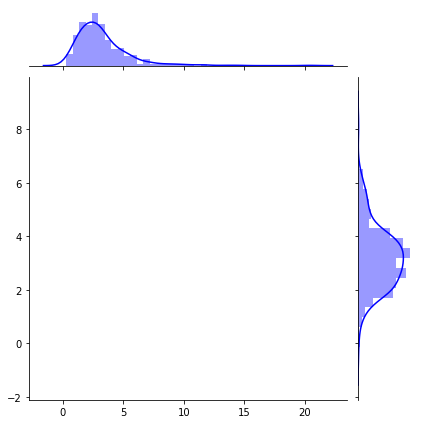

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(robs, linrpredictions,
                ax=ax,
                marker='+',
                hue=ndf['lon'],
                )

sns.lineplot(robs.T, 
          robs.T,
             ax=ax,
          color='r',
            dashes=True)

sns.jointplot(robs, linrpredictions, ax=ax,  kind='reg', color='blue', marker='+',scatter_kws={"s": 0.01})

ax.set_xlabel('Observations')
ax.set_ylabel('Reconstruction')

slope, intercept, r_value, p_value, std_err = linregress(robs, linrpredictions)
print("slope", slope, "r2_val", r_value)

print("Std deviation ratio of vectors [models/]:", np.mean(np.std(iens, axis=1))/np.std(robs))

slope 0.3366430702110283 r2_val 0.5802095054469794
Std deviation ratio of vectors [models/]: 0.9787770748404654


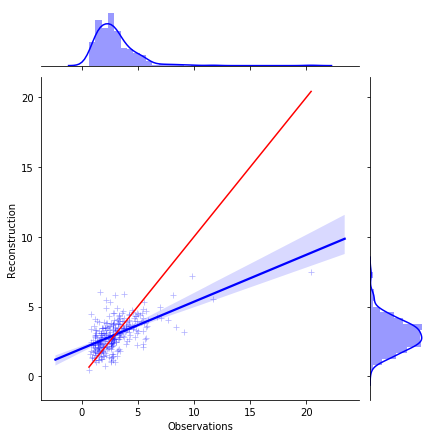

In [74]:
sns.jointplot(robs, linrpredictions, kind='reg', color='blue', marker='+',scatter_kws={"s": 0.01})
sns.scatterplot(robs, linrpredictions, 
                color="blue",
                marker='+',
                alpha=0.3)

sns.lineplot(robs.T, 
          robs.T,
          color='r',
            dashes=True)

plt.xlabel('Observations')
plt.ylabel('Reconstruction')

slope, intercept, r_value, p_value, std_err = linregress(robs, linrpredictions)
print("slope", slope, "r2_val", r_value)

print("Std deviation ratio of vectors [models/]:", np.mean(np.std(iens, axis=1))/np.std(robs))

In [31]:
dv_recon = interp_dict['iens'][0, ...].copy()
dv_recon[master_idx] = rmodel.predict(vT.T)

In [32]:
dv_recon_sq = dv_recon.reshape(interp_dict['irlat'].shape[0], interp_dict['irlon'].shape[0])

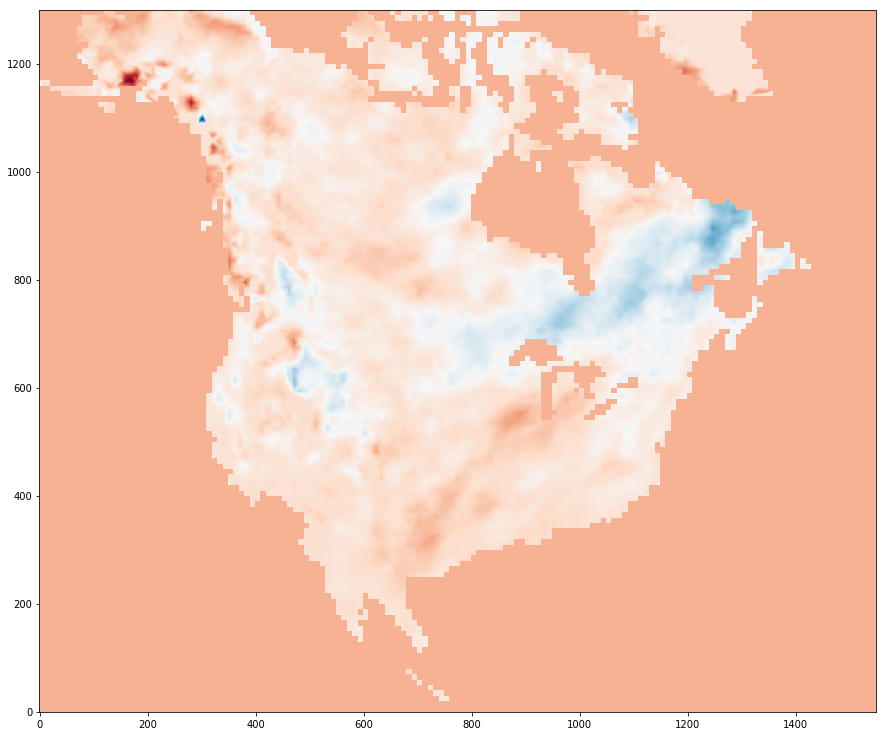

In [33]:
plt.figure(figsize=(15, 15))
plt.imshow(dv_recon_sq, cmap='RdBu', origin='lower')
plt.savefig('reconstruction_snow.pdf')